# NYPD Fare Evasion Enforcement's Disparate Impact
Leena Kahlon, Dylan Fosgett, Woo Hyuk Chang and Rebecca Dorn
University of California, Santa Cruz, Fall 2019

<img src="https://pbs.twimg.com/media/EJAwu4gWsAoPKwL?format=jpg&name=medium">

*Image from Twitter's @DecolonizeThisPlace*

## Introduction
***
Imagine your loan application has just been rejected by your bank. You ask them why, and they respond that the neighborhood you live in scored poorly for likelihood to pay the loan back. For some reason this bank has the algorithm they use online. You look into it a bit more, and you realize that though the bank does not use race as a feature, those who live in predominantly African American neighborhoods are almost three times as likely to be denied a loan. Disparate impact refers to "when policies, practices, rules or other systems that appear to be neutral result in a disproportionate impact on a protected group". No one in the bank sat down and say "hey, I'm going to create a fairly racist predictor!". But, the rules that the bank goes by dispraportionately impact African Americans. Situations like these are all too common in the United States, and they must be addressed.

On October 28, 2019, a video of around ten police officers tackling and pulling guns on a black teen for evading the \$2.75 subway fare in New York City went viral. Communities were enraged to see this fierceley violent attack on a teen of color over such a small fare. A few months before, the MTA calculated that they were losing millions annually due to those who evade paying the transit fare. The MTA decided to deploy 500 new officers to watch for turnstile hoppers, in hopes of losing less money. While in theory this plan makes sense, we can't help but wonder. What kind of disparate impact against communities of color is happening? What about against lower income communities?


## Setup: Installing Necessary Libraries
```pip install matplotlib
pip install numpy
pip install pandas
pip install geopandas
pip install beautifulsoup4
pip install seaborn
pip install twitter
pip install nltk```

Cooresponding files can be found on git: https://github.com/rebdorn/fare_evasion

## Project
***
We organize our project into distinct portions
1. Web Scraping
2. Data Wrangling
3. Data Visualization

Our goal is to create an easy-to-use visualization to answer the following research questions:
1. How has fare evasion enforcement in New York City changed in recent years?
2. What subway stations have an outstanding number of recent police sightings? What are the demographics around these stations?
3. What are the fare evasione enforcement trends around stations with outstanding numbers of recent police sightings?
4. What is the overlap between stations with more police sightings and stations with more fare evasion enforcement?

# Web Scraping
***
To get recent police sightings, we scrape twitter account @unfarenyc. This is an account where people send information about police sightings at subway stations, and they post the number of cops and which subway station. We scrape the twitter account these sightings using nltk and bear's python twitter wrapper. Note that to run this code on your account, you must posess a secret key given by the Twitter API.

We begin by running some import statements. Make sure to run this cell, or else the code won't work!

In [1]:
# Some import statements to make our code run
from itertools import permutations
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import twitter
import nltk

**Scraping the Twitter API:** We use bare's Python wrapper for the twitter API to make our life easier. The operations we do occur as follows:
- Connect to the Twitter API using our given keys. (Note: a key is not provided in this demo, make sure to plug your own key into git.ignore before running thic cell!)
- Get the entirety of @UnfareNYC's timeline. The function "GetUserTimeine" requires we specify the number of tweets to request, and the maximum is 200. Because of this, we need to recursively find the earliest tweet out of the 200 we get, and use that as an end point for the 200 tweets beforehand.
- The twitter API gives us a hefty amount of information. So, store only our most desired information in our dataframe: ID, User, created_at and text.

In [2]:
CONSUMER_KEY = '0ift2jAgEYQrWs8OP1f9TjRQ1'
CONSUMER_SECRET = 'qq9jNTaS3cG9wVc2Hxij3M0GuhAy72wNzFnBc9y1ejp2xh5dg4'
ACCESS_TOKEN_KEY = '144353594-pUtB5UxLeZHwZxJH4vPtFQMXAvgyQKTyvDanafog'
ACCESS_TOKEN_SECRET = 'TvGH6dRf2J0PTKgBiSwWJ022j25PNBBaYUZQYWML1bDok'

# connect to twitter API with our given user credentials
api = twitter.Api(consumer_key = CONSUMER_KEY,
                      consumer_secret = CONSUMER_SECRET,
                      access_token_key = ACCESS_TOKEN_KEY,
                      access_token_secret = ACCESS_TOKEN_SECRET)

In [3]:
# Scrape @unfarenyc's twitter timeline
statuses_list = api.GetUserTimeline(count=200,screen_name='unfarenyc') # Load @unfarenyc's timeline

# To get earlier tweets we continuously find the minimum and get the 200 previous
earliest_tweet = min(statuses_list, key=lambda x: x.id).id # Find the last tweet we were allowed to get
while True: # While there are more tweet to get
    nexttweets = api.GetUserTimeline(screen_name='unfarenyc', max_id=earliest_tweet, count=200)
    new_earliest = min(nexttweets, key=lambda x: x.id).id
    if not nexttweets or new_earliest == earliest_tweet:
        break
    else:
        earliest_tweet = new_earliest
        statuses_list += nexttweets

In [4]:
# Store the desired information into a dataframe
tweets = []
for s in statuses_list:
    tweets.append([s.id,s.user.screen_name,s.created_at,s.text,s.retweet_count])
tweetsdf = pd.DataFrame(tweets,columns=['ID','user','created_at','text','retweets'])

We define two functions. One to process subway station names such that they are all lowercase, we separate "2nd" to "2" and "nd" (Same with formats of 1st, 17th) and change some common phrases to be short and don't include vowels. Secoond function is to change unigrams to match station names-- we remove some specific punctuation and change park -> pk, etc.

In [126]:
# Our NLP protocol for getting unigrams into a usable form
def process_unigram(unigram, st_bool = 1):
    if st_bool == 1:
        if unigram[0].isdigit() & unigram.endswith('st'): # Are we of form "1"st?
            unigram = unigram[:-2] + " " + 'st' # Shorten unigram to only that street number
    if unigram[0].isdigit() & unigram.endswith('nd'): # Are we of form "2"nd?
        unigram = unigram[:-2] # Shorten unigram to just that number
    elif unigram[0].isdigit() and unigram.endswith('th'): # Are we of form "10"th?
        unigram = unigram[:-2] # Shorten unigram to only that number
    elif unigram[0].isdigit() and unigram.endswith('rd'): # Are we of form "10"th?
        unigram = unigram[:-2] # Shorten unigram to only that number
    elif unigram == 'park': # If this unigram reads 'park'
        unigram = 'pk' # Shorten it to match our station names
    elif unigram == 'parkway': # If this unigram reads "parkway"
        unigram = 'pkwy' # Shorten it to match our station names
    elif unigram == 'heights': # If this unigram reads "heights"
        unigram = 'hts' # Shorted it to match our station names
    elif unigram == 'ave':
        unigram = 'av'
    elif unigram == 'place':
        unigram = 'pl'
    elif unigram == 'street':
        unigram = 'st'
    elif unigram == 'avenue':
        unigram = 'av'
    elif unigram == 'avnue':
        unigram = 'av'
    return unigram

# Our NLP protocol for processing subway names (removing punct, etc.)
def process_stations(df_col):
    processed_tweets = df_col.str.replace(" - "," ")
    processed_tweets = processed_tweets.str.replace("-"," ")
    processed_tweets = processed_tweets.str.replace("/"," ")
    processed_tweets = processed_tweets.str.replace(".","")
    processed_tweets = processed_tweets.str.replace("'","")
    processed_tweets = processed_tweets.str.replace("(","")
    processed_tweets = processed_tweets.str.replace(")","")
    processed_tweets = processed_tweets.str.lower()
    processed_tweets = processed_tweets.str.replace("ave","av")
    processed_tweets = processed_tweets.str.replace("avenue", "av")
    processed_tweets = processed_tweets.str.replace("street","st")
    processed_tweets = processed_tweets.str.replace("square","sq")
    processed_tweets = processed_tweets.str.replace("place", "pl")
    processed_tweets = processed_tweets.str.replace("heights","hts")
    processed_tweets = processed_tweets.str.replace("park","pk")
    processed_tweets = processed_tweets.str.replace("jay st metrotech","jay st")
    return processed_tweets

Process the subway names, create a list of subway station names to later check tweets

In [127]:
# Read the CSV file of Subway Station names and process the names
stations = pd.read_csv("Stations.csv")

# Process the station names, convert to list for easy searching
station_names = list(process_stations(stations['Stop Name']))

# Process the tweets such that it sepearates hyphens, we process unigrams more later.
processed_tweets = process_stations(tweetsdf['text'])

# Add new empty column to tweetsdf to store station names
tweetsdf['station_referral'] = np.nan


Create column of datetime objects

In [128]:
from datetime import date

# A simple mapping of the first 3 letters of months to their numerical representation
month_number = { 'Jan' : 1, 'Feb' : 2, 'Mar' : 3, 'Apr' : 4,
                'May': 5, 'Jun' : 6, 'Jul' : 7, 'Aug' : 8,
                'Sep' : 9, 'Oct' : 10, 'Nov' : 11, 'Dec' : 12}

# Create a new column in the tweets dataframe for our datetime objects and populate
tweetsdf['created_at_datetime'] = np.nan
for k, instance in enumerate(tweetsdf['created_at']): # for each tweet's creation time/day
    for i, chunk in enumerate(instance.split(" ")): # parse through the datetime, split by space
        if i == 1:
            this_month = month_number[chunk]
        elif i == 2:
            this_day = int(chunk)
        elif i == 5:
            this_year = int(chunk)
    tweet_datetime = date(year = this_year, month = this_month, day = this_day)
    tweetsdf.loc[k,'created_at_datetime'] = tweet_datetime

Loop through tweets, check fourgram -> unigram if this is a station name (Bigger name first helps ensure we get right station)

In [140]:
# Loop through each tokened tweet and look for the subway station

for i, row in enumerate(processed_tweets.apply(nltk.tokenize.word_tokenize)):
    found = 0 # At the beginning of each tweet, reset bool found
    #print(row)
    for fourgram in nltk.ngrams(row,4): # Check each combo of 4 tokens in tweet
        if found == 1:
            break
        one, two, three, four = fourgram # Unpack fourgram to permute versions of tuple
        one = process_unigram(one)
        two = process_unigram(two)
        three = process_unigram(three)
        four = process_unigram(four)
        for ordering in permutations([one, two, three, four]): # For each possible ordering of these unigrams
            perm_one, perm_two, perm_three, perm_four = ordering # Unpack this permutation
            if perm_one+" "+perm_two+" "+perm_three+" "+perm_four in station_names[:]: # If this permutation is a station name
                tweetsdf.loc[i,'station_referral'] = perm_one+" "+perm_two+" "+perm_three+" "+perm_four # Put the data in our dataframe
                found = 1 # Signal that for this tweet we have found the station
                break # Break out of the loop!
    
    if found != 1: # If we have checked all fourgrams and did not find the subway station
        for trigram in nltk.trigrams(row):
            if found == 1:
                break
            one, two, three = trigram
            one = process_unigram(one)
            two = process_unigram(two)
            three = process_unigram(three)
            for ordering in permutations([one, two, three]):
                perm_one, perm_two, perm_three = ordering
                if perm_one+" "+perm_two+" "+perm_three in station_names[:]:
                    tweetsdf.loc[i,'station_referral'] = perm_one+" "+perm_two+" "+perm_three
                    found = 1
                    break
                
    if found != 1:
        for bigram in nltk.bigrams(sorted(row, reverse = True)):
            if found == 1:
                break
            one, two = bigram
            one = process_unigram(one)
            two = process_unigram(two)
            for ordering in permutations([one, two]):
                perm_one, perm_two = ordering
                #print(perm_one, perm_two, (perm_one+" "+perm_two in station_names[:]))
                if perm_one+" "+perm_two in station_names[:]:
                    tweetsdf.loc[i,'station_referral'] = perm_one+" "+perm_two
                    found = 1
                    break
                
    if found != 1:
        for unigram in row:
            if found == 1:
                break
            unigram = process_unigram(unigram, st_bool = 0)
            if unigram[0].isdigit() and unigram.endswith('st'):
                if unigram[:-2] + " " + "st" in station_names[:]:
                    tweetsdf.loc[i,'station_referral'] = unigram[:-2] + " " + "st"
                    found = 1
                    break
        unigram = process_unigram(unigram)
        if found != 1:
            for unigram in sorted(row, reverse = True):
                if found == 1:
                    break
                if unigram in station_names[:]:
                    tweetsdf.loc[i,'station_referral'] = unigram
                    found = 1
                    break  
                elif unigram+" st" in station_names[:]:
                    tweetsdf.loc[i,'station_referral'] = unigram+" st"
                    found = 1
                    break
                elif unigram+" av" in station_names[:]:
                    tweetsdf.loc[i,'station_referral'] = unigram+" av"
                    found = 1
                    break         

For our project, we map out 24 specific stations such that each transit district has one high count station and one low count station. Let's take a look at how we chose Transit district 2-- feel free to do the same for the other transit districts via how we did this one!

/Users/beccadorn/miniconda3/lib/python3.7/site-packages/pandas/core/series.py:1152: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


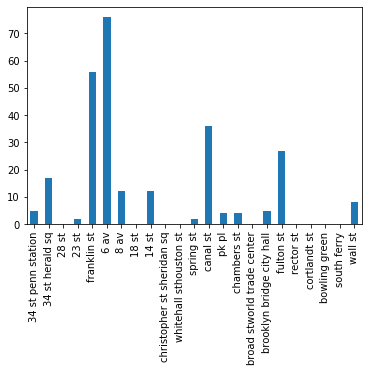

In [144]:
# Store a list of the processed versions of all stations in transit district 2
transit_district_2_stations = ['34 st penn station', '34 st herald sq', '28 st', '23 st', 'franklin st',
                               '6 av', '8 av', '18 st', '14 st', 'christopher st sheridan sq', 'whitehall st'
                               'houston st', 'spring st', 'canal st', 'pk pl', 'chambers st', 'broad st'
                               'world trade center', 'brooklyn bridge city hall', 'fulton st', 'rector st',
                               'cortlandt st', 'bowling green', 'south ferry', 'wall st']

# Get a counter of sightings for all stations (then we'll narrow it down to the desired stations)
station_referral_counts = tweetsdf['station_referral'].value_counts()
transit_district_2_sightings = station_referral_counts[transit_district_2_stations]
transit_district_2_sightings.plot.bar()


We take a look at the 3 highest counted stations 6 av, canal st and 14 st. We look at their average ridership.

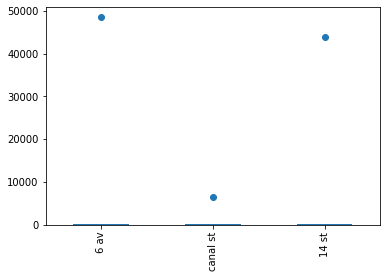

In [145]:
# Let's take a better look at 3 stations: 6 av, canal st and 14 st
transit_district_highest = ['6 av', 'canal st', '14 st']
avg_weekday_ridership_2018 = [48508, 6410, 44031]
station_referral_counts[transit_district_highest].plot.bar()
plt.plot(avg_weekday_ridership_2018,'o')

We now do a few last things: bin a station's tweets by-week, get the average number of police station sightings per-week, and create visualizations of the two for the 24 stations we've chosen to focus on.

In [146]:
# create a series of data ranges we check (Every sunday since its been created)
weekly_bins = pd.date_range(start = '2019-08-04', end = '2019-11-30',freq = 'W-SUN')

# Plot average sightings per week
averagecount_array = [np.nan] * len(weekly_bins)
for i, week in enumerate(weekly_bins):
    daysofweek = pd.date_range(start = week, freq = 'D', periods = 7)
    view = np.where((daysofweek[0] >= tweetsdf['created_at_datetime']) & (tweetsdf['created_at_datetime'] <= daysofweek[6]), 1, 0)
    averagecount_array[i] = np.count_nonzero(view)

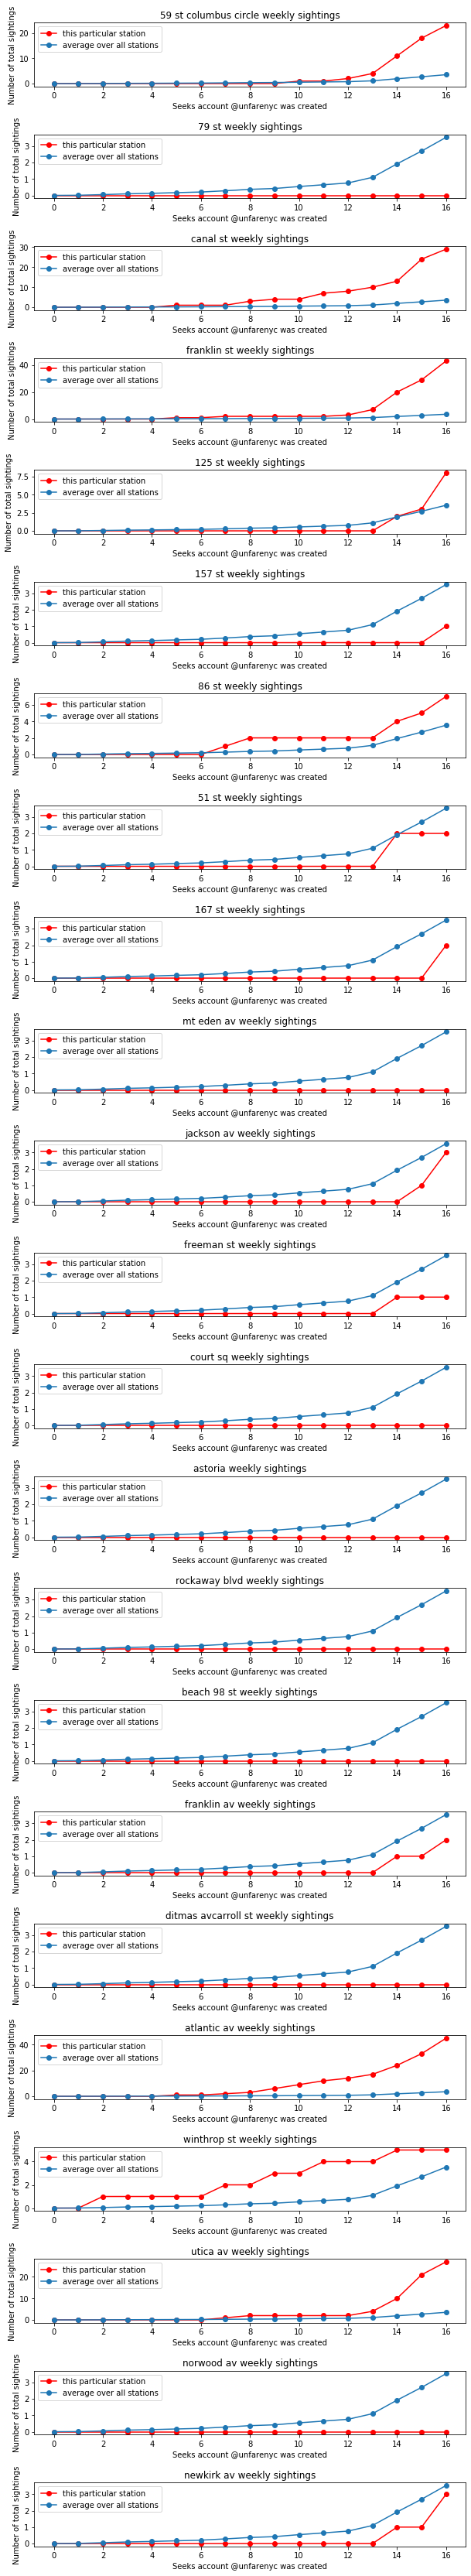

In [147]:
# Function to easily get weekly police counts of a station
def weeklycounts_fromstation(station_name):
    # Get the tweets about our station name
    station_tweets = tweetsdf.loc[tweetsdf['station_referral'] == station_name]
    count_array = [np.nan] * int(len(weekly_bins))
    for i, week in enumerate(weekly_bins):
        daysofweek = pd.date_range(start = week, freq = 'D', periods = 7)
        view = np.where((daysofweek[0] >= station_tweets['created_at_datetime']) & (station_tweets['created_at_datetime'] <= daysofweek[6]), 1, 0)
        count_array[i] = np.count_nonzero(view)
    return count_array 

# Get average number of police sightings
average_plot = []
for i, item in enumerate(averagecount_array):
    average_plot.append(averagecount_array[i] / len(station_names))

chosen_stations = ['59 st columbus circle', '79 st', 'canal st', 'franklin st', '125 st',
                  '157 st', '86 st', '51 st', '167 st', 'mt eden av', 'jackson av', 'freeman st',
                  'court sq', 'astoria', 'rockaway blvd', 'beach 98 st', 'franklin av', 'ditmas av'
                  'carroll st', 'atlantic av', 'winthrop st', 'utica av', 'norwood av', 'newkirk av']

fig, axes = plt.subplots(len(chosen_stations),figsize = (10,60))
plt.subplots_adjust(hspace = 0.75)
for i, station in enumerate(chosen_stations):
    count_array = weeklycounts_fromstation(station)
    axes[i].plot(count_array,'-or', label = 'this particular station')
    axes[i].plot(average_plot, '-o', label = 'average over all stations')
    axes[i].set_title(station+" weekly sightings")
    axes[i].set_xlabel("Seeks account @unfarenyc was created")
    axes[i].set_ylabel("Number of total sightings")
    axes[i].legend(loc='best')


## Data Wrangling
***
We further split our data wrangling into three parts:
1. Wrangling at the Community District level
2. Wrangling at the Transit District level

### Wrangling at the Community District level

In [ ]:
from pandas import Series, DataFrame

district_demo = pd.read_csv('sf1_dp_cd_demoprofile.csv')
district_demo

In [ ]:
data_numbers = {'Total': [], 
                'White': [], 
                'Black': [], 
                'Asian': [], 
                'Other': [], 
                'Two or more races': [], 
                'Hispanic': [], 
                'Female': [], 
                'Male': [], 
                'Under 5 years': [], 
                '5 to 9 years': [], 
                '10 to 14 years': [], 
                '15 to 19 years': [], 
                '20 to 24 years': [], 
                '25 to 44 years': [], 
                '45 to 64 years': [], 
                '65 years and over': []}
data_percentages = {'Total': [], 
                    'White': [], 
                    'Black': [], 
                    'Asian': [], 
                    'Other': [], 
                    'Two or more races': [], 
                    'Hispanic': [], 
                    'Female': [], 
                    'Male': [], 
                    'Under 5 years': [], 
                    '5 to 9 years': [], 
                    '10 to 14 years': [], 
                    '15 to 19 years': [], 
                    '20 to 24 years': [], 
                    '25 to 44 years': [], 
                    '45 to 64 years': [], 
                    '65 years and over': []}
frame_numbers = pd.DataFrame(data_numbers)
frame_percentages = pd.DataFrame(data_percentages)

In [ ]:
district_demo.rename(columns = {'Table SF1-DP CD: Demographic Profile - New York City Community Districts': 'Districts',
                                'Unnamed: 1': 'Category', 'Unnamed: 5': '2000 Number', 'Unnamed: 6': '2000 Percent',
                                'Unnamed: 7': '2010 Number', 'Unnamed: 8': '2010 Percent', 'Unnamed: 9': 'Change Number', 
                                'Unnamed: 10': 'Change Percent'})

In [ ]:
categories = ['Total', 'White', 'Black', 'Asian', 'Other', 'Two or more races', 'Hispanic', 'Female', 'Male', 
             'Under 5 years', '5 to 9 years', '10 to 14 years', '15 to 19 years', '20 to 24 years', '25 to 44 years', 
             '45 to 64 years', '65 years and over']
row_index_start = 78
dfcolumn = 0
for i in range(0, 17):
    count = 1
    column_index = 7
    numbers = []
    row_index = row_index_start
    while(count < 60):
        if(row_index <= 4378):
            numbers.append(district_demo.iloc[row_index, column_index])
            row_index = row_index + 73
            count = count + 1
    frame_numbers[categories[dfcolumn]] = numbers
    dfcolumn = dfcolumn + 1
    if row_index_start == 84 or row_index_start == 87:
        row_index_start = row_index_start + 2
    else:
        row_index_start = row_index_start + 1

row_index_start = 78
dfcolumn = 0
for i in range(0, 17):
    count = 1
    column_index = 8
    numbers = []
    row_index = row_index_start
    while(count < 60):
        if(row_index <= 4378):
            numbers.append(district_demo.iloc[row_index, column_index])
            row_index = row_index + 73
            count = count + 1
    frame_percentages[categories[dfcolumn]] = numbers
    dfcolumn = dfcolumn + 1
    if row_index_start == 84 or row_index_start == 87:
        row_index_start = row_index_start + 2
    else:
        row_index_start = row_index_start + 1
    

In [ ]:
districts = ['Bronx_1', 'Bronx_2', 'Bronx_3', 'Bronx_4', 'Bronx_5', 'Bronx_6', 'Bronx_7', 'Bronx_8', 'Bronx_9', 'Bronx_10', 'Bronx_11', 'Bronx_12', 
                       'Brooklyn_1', 'Brooklyn_2', 'Brooklyn_3', 'Brooklyn_4', 'Brooklyn_5', 'Brooklyn_6', 'Brooklyn_7', 'Brooklyn_8', 'Brooklyn_9',
                       'Brooklyn_10', 'Brooklyn_11', 'Brooklyn_12', 'Brooklyn_13', 'Brooklyn_14', 'Brooklyn_15', 'Brooklyn_16', 'Brooklyn_17', 'Brooklyn_18',
                       'Manhattan_1', 'Manhattan_2', 'Manhattan_3', 'Manhattan_4', 'Manhattan_5', 'Manhattan_6', 'Manhattan_7', 'Manhattan_8', 'Manhattan_9', 
                       'Manhattan_10', 'Manhattan_11', 'Manhattan_12', 'Queens_1', 'Queens_2', 'Queens_3', 'Queens_4', 'Queens_5', 'Queens_6', 'Queens_7',
                       'Queens_8', 'Queens_9', 'Queens_10', 'Queens_11', 'Queens_12', 'Queens_13', 'Queens_14', 'StatenIsland_1', 'StatenIsland_2', 'StatenIsland_3']
frame_numbers.index = districts
frame_percentages.index = districts

In [ ]:
frame_numbers

In [ ]:
frame_percentages

In [ ]:
household_income = pd.read_csv('sub-borougharea-medianhouseholdincome2018.csv')
nyc_household_income = pd.read_csv('city-medianhouseholdincome2018.csv')

In [ ]:
household_income

In [ ]:
nyc_household_income

In [ ]:
for i in range(5, 40):
    x, y = 0, 0
    if i < 13:
        x, y = 5, 1
    elif i > 13 and i < 17:
        x, y = 6, 1
    elif i > 23 and i < 40:
        x, y = 13, 1
    else: 
        y = 0
        
    if y == 1:
        a, b = household_income.iloc[i].copy(), household_income.iloc[i-x].copy()
        household_income.iloc[i], household_income.iloc[i-x] = b, a

a, b = household_income.iloc[29].copy(), household_income.iloc[35].copy()
household_income.iloc[29], household_income.iloc[35] = b, a

a, b = household_income.iloc[36].copy(), household_income.iloc[37].copy()
household_income.iloc[36], household_income.iloc[37] = b, a

a, b = household_income.iloc[37].copy(), household_income.iloc[38].copy()
household_income.iloc[37], household_income.iloc[38] = b, a

a, b = household_income.iloc[38].copy(), household_income.iloc[27].copy()
household_income.iloc[38], household_income.iloc[27] = b, a

a, b = household_income.iloc[39].copy(), household_income.iloc[28].copy()
household_income.iloc[39], household_income.iloc[28] = b, a

for i in range(28, 8, -1):
    a, b = household_income.iloc[i].copy(), household_income.iloc[i-1].copy()
    household_income.iloc[i], household_income.iloc[i-1] = b, a

for i in range(28, 52, 2):
    a, b = household_income.iloc[i].copy(), household_income.iloc[i+1].copy()
    c, d = household_income.iloc[i+2].copy(), household_income.iloc[i+3].copy()
    
    household_income.iloc[i], household_income.iloc[i+1] = c, d
    household_income.iloc[i+2], household_income.iloc[i+3] = a, b

a, b = household_income.iloc[52].copy(), household_income.iloc[53].copy()
household_income.iloc[52], household_income.iloc[53] = b, a

In [ ]:
household_income.drop(['short_name', 'long_name', '2000'], axis=1, inplace=True)
districts1 = ['Bronx_1', 'Bronx_3', 'Bronx_4', 'Bronx_5', 'Bronx_7', 'Bronx_8', 'Bronx_9', 'Bronx_x10', 'Bronx_x11', 'Bronx_x12', 
                       'Brooklyn_1', 'Brooklyn_2', 'Brooklyn_3', 'Brooklyn_4', 'Brooklyn_5', 'Brooklyn_6', 'Brooklyn_7', 'Brooklyn_8', 'Brooklyn_9',
                       'Brooklyn_x10', 'Brooklyn_x11', 'Brooklyn_x12', 'Brooklyn_x13', 'Brooklyn_x14', 'Brooklyn_x15', 'Brooklyn_x16', 'Brooklyn_x17', 'Brooklyn_x18',
                       'Manhattan_1', 'Manhattan_3', 'Manhattan_4', 'Manhattan_6', 'Manhattan_7', 'Manhattan_8', 'Manhattan_9', 
                       'Manhattan_x10', 'Manhattan_x11', 'Manhattan_x12', 'Queens_1', 'Queens_2', 'Queens_3', 'Queens_4', 'Queens_5', 'Queens_6', 'Queens_7',
                       'Queens_8', 'Queens_9', 'Queens_x10', 'Queens_x11', 'Queens_x12', 'Queens_x13', 'Queens_x14', 'StatenIsland_1', 'StatenIsland_2', 'StatenIsland_3']
districts2 = ['Bronx_2', 'Bronx_6', 'Manhattan_2', 'Manhattan_5']

household_income.index = districts1
household_income

In [ ]:
household_income.columns
household_income_2 = pd.DataFrame(index = districts2, columns = household_income.columns)
household_income_2

In [ ]:
bronx_2_income = pd.Series(household_income.loc['Bronx_1'])
bronx_6_income = pd.Series(household_income.loc['Bronx_3'])
manhattan_2_income = pd.Series(household_income.loc['Manhattan_1'])
manhattan_5_income = pd.Series(household_income.loc['Manhattan_4'])

household_income_2.loc['Bronx_2'] = bronx_2_income
household_income_2.loc['Bronx_6'] = bronx_6_income
household_income_2.loc['Manhattan_2'] = manhattan_2_income
household_income_2.loc['Manhattan_5'] = manhattan_5_income

household_income_2

In [ ]:
frames = [household_income, household_income_2]

household_income = pd.concat(frames)

household_income.sort_index(inplace=True)
household_income

In [ ]:
household_income.index = districts
household_income.drop(['Sub-Borough Area'], axis=1, inplace=True)

years = ['05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18']
household_income.columns = years
household_income

In [ ]:
nyc_household_income.drop(['City', 'short_name', 'long_name', '2000'], axis=1, inplace=True)
nyc_household_income.columns = years
nyc_household_income

### Wrangling at the Transit District level

In [3]:
# More code and descriptions, etc.
from functools import reduce
df = pd.read_excel('genderarrests.xlsx')
df.columns = ['Transit_District', 'Female', 'Male', 'Grand Total']   # Specify column names.
df = df[df.Transit_District != 'Transit Distict']                    # Remove typo and repeating column headers.
df = df[df.Transit_District.notnull()]                               # Remove NaN lines
df = df.drop('Grand Total', axis=1)                                  # Grand Totals removed because we can calc at the end.
my_df1 = df.groupby('Transit_District')['Female'].apply(list).apply(pd.Series)
my_df1.columns = ['FEMALE'+str(i) for i in my_df1.columns]
my_df2 = df.groupby('Transit_District')['Male'].apply(list).apply(pd.Series)
my_df2.columns = ['MALE'+str(i) for i in my_df2.columns]
my_df3 = pd.merge(my_df1, my_df2, left_on='Transit_District', right_on='Transit_District', how='left')
my_df3['Grand Total'] = my_df3.sum(axis=1)
my_df3 = my_df3.iloc[np.r_[0:len(my_df3) - 2, -1, -2]]                               # Flip Grand Total and Unknown (for some reason was flipped)
my_df3.loc['Grand Total'] = my_df3.loc['Grand Total'] - my_df3.loc['Unknown']        # Subtract Unknown values from Grand Total
i = my_df3[(my_df3.FEMALE0 == 18) & ( my_df3.FEMALE1 == 15)].index
my_df3.drop(i, inplace=True)
my_df3

,FEMALE0,FEMALE1,FEMALE2,FEMALE3,FEMALE4,FEMALE5,FEMALE6,MALE0,MALE1,MALE2,MALE3,MALE4,MALE5,MALE6,Grand Total
Transit_District,,,,,,,,,,,,,,,
01,41,22,6,3,4,0,2,481,257,53,53,61,43,34,1060
02,18,7,4,0,2,1,0,228,97,22,13,27,26,9,454
03,9,7,1,2,4,2,3,160,100,15,20,27,28,21,399
04,38,17,6,5,2,15,6,517,325,61,51,57,71,53,1224
11,13,11,9,8,8,5,3,266,131,76,93,94,102,51,870
12,17,15,10,20,22,21,10,269,178,99,146,199,187,93,1286
20,13,13,3,1,6,4,2,152,105,66,54,36,53,41,549
23,9,7,4,4,2,4,2,79,51,32,22,11,24,21,272
30,27,17,18,21,9,13,14,219,156,106,73,58,94,85,910


In [4]:
ef = pd.read_excel('gendersummons.xlsx') 
ef.columns = ['Transit_District', 'Female', 'Male', 'UNKNOWN', 'Grand Total']     # Specify column names.
ef = ef[ef.Transit_District != 'Transit Distict']                                 # Remove typo and repeating column headers.
ef = ef[ef.Transit_District.notnull()]                                            # Remove NaN lines
ef = ef.drop(['Grand Total', 'UNKNOWN'], axis=1)                                  # Grand Totals removed because we can calc at the end.
my_ef1 = ef.groupby('Transit_District')['Female'].apply(list).apply(pd.Series)
my_ef1.columns = ['FEMALE'+str(i) for i in my_ef1.columns]
#'FEMALE0', 'FEMALE1', 'FEMALE2', 'FEMALE3', 'FEMALE4', 'FEMALE5', 'FEMALE6'
my_ef2 = ef.groupby('Transit_District')['Male'].apply(list).apply(pd.Series)
my_ef2.columns = ['MALE'+str(i) for i in my_ef2.columns]
my_ef3 = pd.merge(my_ef1, my_ef2, left_on='Transit_District', right_on='Transit_District', how='left')
#my_df3.columns = ['Transit_District', 'FEMALE0', 'FEMALE1', 'FEMALE2', 'FEMALE3', 'FEMALE4', 'FEMALE5', 'FEMALE6', 'MALE0', 'MALE1', 'MALE2', 'MALE3', 'MALE4', 'MALE5', 'MALE6']
#df.head(16)
my_ef3['Grand Total'] = my_ef3.sum(axis=1)
#my_ef3 = my_ef3.iloc[np.r_[0:len(my_ef3) - 2, -1, -2]]
my_ef3

,FEMALE0,FEMALE1,FEMALE2,FEMALE3,FEMALE4,FEMALE5,FEMALE6,MALE0,MALE1,MALE2,MALE3,MALE4,MALE5,MALE6,Grand Total
Transit_District,,,,,,,,,,,,,,,
01,538,494,456,652,791,990,672,1241,1179,1083,1547,1806,1891,1371,14711
02,375,363,340,454,557,579,424,695,656,626,841,1066,1044,625,8645
03,172,134,141,239,245,397,382,446,319,381,592,724,1052,885,6109
04,353,343,375,574,595,880,562,874,885,791,1107,1226,1675,1171,11411
11,170,120,135,205,252,275,471,490,506,641,888,922,1049,1339,7463
12,127,105,185,524,438,616,505,425,412,571,1650,1597,1789,1409,10353
20,293,258,281,251,261,304,296,669,644,694,623,661,861,731,6827
23,91,115,79,82,90,130,138,250,279,240,241,226,319,297,2577
30,529,359,378,353,371,546,465,850,625,730,813,785,1122,1075,9001


In [5]:
ff = pd.read_excel('racearrests.xlsx')
ff.columns = ['Transit_District', 'American Indian', 'Asian/Pac Isl', 'Black', 'Hispanic', 'Unknown', 'White', 'Grand Total']
ff = ff[ff.Transit_District != 'Transit Distict']                    # Remove typo and repeating column headers.
ff = ff[ff.Transit_District.notnull()]                               # Remove NaN lines
ff = ff.drop(['Grand Total', 'Unknown'], axis=1)
ff1 = ff.groupby('Transit_District')['American Indian'].apply(list).apply(pd.Series)
ff1.columns = ['American Indian'+str(i) for i in ff1.columns]

ff2 = ff.groupby('Transit_District')['Asian/Pac Isl'].apply(list).apply(pd.Series)
ff2.columns = ['Asian/PacIsl'+str(i) for i in ff2.columns]

ff3 = ff.groupby('Transit_District')['Black'].apply(list).apply(pd.Series)
ff3.columns = ['Black'+str(i) for i in ff3.columns]

ff4 = ff.groupby('Transit_District')['Hispanic'].apply(list).apply(pd.Series)
ff4.columns = ['Hispanic'+str(i) for i in ff4.columns]

ff5 = ff.groupby('Transit_District')['White'].apply(list).apply(pd.Series)
ff5.columns = ['White'+str(i) for i in ff5.columns]

ffs = reduce(lambda x,y: pd.merge(x,y, on='Transit_District', how='outer'), [ff1, ff2, ff3, ff4, ff5])
ffs = ffs.iloc[np.r_[0:len(ffs) - 2, -1, -2]]
ffs.loc['Grand Total'] = ffs.loc['Grand Total'] - ffs.loc['Unknown']
i = ffs[(ffs.White0 == 19) & ( ffs.White1 == 14)].index
ffs.drop(i, inplace=True)
ffs['Grand Total'] = ffs.sum(axis=1)
ffs

,American Indian0,American Indian1,American Indian2,American Indian3,American Indian4,American Indian5,American Indian6,Asian/PacIsl0,Asian/PacIsl1,Asian/PacIsl2,...,Hispanic5,Hispanic6,White0,White1,White2,White3,White4,White5,White6,Grand Total
Transit_District,,,,,,,,,,,,,,,,,,,,,
01,0,1,0,0,0,0,0,15,9,2,...,17,6,42,18,5,5,8,7,9,1054
02,0,1,0,0,0,0,0,8,2,0,...,6,4,28,12,1,2,3,4,1,444
03,0,0,0,0,0,0,0,1,0,0,...,8,8,7,5,0,2,0,3,2,398
04,0,1,0,1,0,0,0,7,3,1,...,29,18,38,22,2,5,6,14,11,1211
11,1,0,0,0,0,0,0,0,3,0,...,39,25,8,5,3,3,2,5,4,867
12,0,0,1,0,0,0,0,3,1,0,...,76,29,5,9,2,4,8,8,5,1281
20,1,1,0,0,0,0,1,15,9,9,...,28,18,8,12,2,0,2,7,2,536
23,1,0,0,0,0,0,0,1,1,2,...,5,1,3,3,1,0,2,1,1,267
30,0,0,0,0,0,0,0,2,1,3,...,18,14,18,16,11,12,6,13,10,904


In [6]:
gf = pd.read_excel('racesummons.xlsx')
gf.columns = ['Transit_District', 'American Indian', 'Asian/Pac Isl', 'Black', 'Hispanic', 'Unknown', 'White', 'Grand Total']
gf = gf[gf.Transit_District != 'Transit Distict']                    # Remove typo and repeating column headers.
gf = gf[gf.Transit_District.notnull()]                               # Remove NaN lines
gf = gf.drop(['Grand Total', 'Unknown'], axis=1)
gf1 = gf.groupby('Transit_District')['American Indian'].apply(list).apply(pd.Series)
gf1.columns = ['American Indian'+str(i) for i in gf1.columns]

gf2 = gf.groupby('Transit_District')['Asian/Pac Isl'].apply(list).apply(pd.Series)
gf2.columns = ['Asian/PacIsl'+str(i) for i in gf2.columns]

gf3 = gf.groupby('Transit_District')['Black'].apply(list).apply(pd.Series)
gf3.columns = ['Black'+str(i) for i in gf3.columns]

gf4 = gf.groupby('Transit_District')['Hispanic'].apply(list).apply(pd.Series)
gf4.columns = ['Hispanic'+str(i) for i in gf4.columns]

gf5 = gf.groupby('Transit_District')['White'].apply(list).apply(pd.Series)
gf5.columns = ['White'+str(i) for i in gf5.columns]

gfs = reduce(lambda x,y: pd.merge(x,y, on='Transit_District', how='outer'), [gf1, gf2, gf3, gf4, gf5])
gfs['Grand Total'] = gfs.sum(axis=1)
gfs

,American Indian0,American Indian1,American Indian2,American Indian3,American Indian4,American Indian5,American Indian6,Asian/PacIsl0,Asian/PacIsl1,Asian/PacIsl2,...,Hispanic5,Hispanic6,White0,White1,White2,White3,White4,White5,White6,Grand Total
Transit_District,,,,,,,,,,,,,,,,,,,,,
01,8,10,7,8,15,13,8,134,117,92,...,832,598,473,431,381,498,676,752,517,13890
02,6,6,8,13,10,5,8,137,125,102,...,363,243,284,295,308,358,435,447,281,7938
03,3,1,0,0,2,2,3,21,23,21,...,445,461,101,77,90,130,154,164,191,5982
04,6,11,3,6,17,12,12,64,89,65,...,665,503,338,352,366,501,544,783,476,10904
11,0,1,0,1,2,1,2,12,13,8,...,669,866,26,21,39,39,37,67,97,7373
12,1,0,1,9,0,7,6,10,8,10,...,1039,912,28,20,24,89,87,126,79,10214
20,11,14,14,12,10,15,19,135,117,123,...,505,430,81,69,79,87,83,77,85,5824
23,4,4,3,1,0,7,2,19,31,17,...,117,88,25,24,23,15,18,21,28,2290
30,2,3,2,2,2,8,1,79,83,84,...,322,301,320,200,220,198,202,314,301,8567


In [7]:
hf = pd.read_excel('agearrests.xlsx')
hf.columns = ['Transit_District', '10-17', '18-24', '25-40', '41-59', '60+', 'Grand Total']
hf = hf[hf.Transit_District != 'Transit Distict']                    # Remove typo and repeating column headers.
hf = hf[hf.Transit_District.notnull()]                               # Remove NaN lines
hf = hf.drop('Grand Total', axis=1)
hf1 = hf.groupby('Transit_District')['10-17'].apply(list).apply(pd.Series)
hf1.columns = ['10-17('+ str(i) + ')' for i in hf1.columns]

hf2 = hf.groupby('Transit_District')['18-24'].apply(list).apply(pd.Series)
hf2.columns = ['18-24('+str(i) + ')' for i in hf2.columns]

hf3 = hf.groupby('Transit_District')['25-40'].apply(list).apply(pd.Series)
hf3.columns = ['25-40('+str(i) + ')' for i in hf3.columns]

hf4 = hf.groupby('Transit_District')['41-59'].apply(list).apply(pd.Series)
hf4.columns = ['41-59('+str(i) + ')' for i in hf4.columns]

hf5 = hf.groupby('Transit_District')['60+'].apply(list).apply(pd.Series)
hf5.columns = ['60+('+str(i) + ')' for i in hf5.columns]

hfs = reduce(lambda x,y: pd.merge(x,y, on='Transit_District', how='outer'), [hf1, hf2, hf3, hf4, hf5])

hfs.loc['Grand Total'] = hfs.loc['Grand Total'] - hfs.loc['Unknown']
hfs.drop('Unknown', inplace=True)
hfs['Grand Total'] = hfs.sum(axis=1)
hfs

,10-17(0),10-17(1),10-17(2),10-17(3),10-17(4),10-17(5),10-17(6),18-24(0),18-24(1),18-24(2),...,41-59(5),41-59(6),60+(0),60+(1),60+(2),60+(3),60+(4),60+(5),60+(6),Grand Total
Transit_District,,,,,,,,,,,,,,,,,,,,,
01,8,4,4,0,0,0,0,186,104,13,...,6,8,9,2,3,1,0,1,2,1060
02,4,2,0,0,0,0,1,70,28,10,...,8,2,5,2,0,1,1,1,0,454
03,3,7,1,0,0,1,1,56,23,7,...,6,7,5,2,0,0,2,0,0,399
04,10,4,2,0,0,0,1,149,79,18,...,24,26,12,8,1,1,2,1,2,1224
11,19,5,0,4,1,0,0,91,43,22,...,31,16,5,3,2,2,1,1,1,870
12,11,6,2,6,3,5,0,97,61,27,...,55,33,4,2,1,3,3,3,3,1286
20,2,8,2,5,0,1,0,68,37,29,...,9,3,2,0,0,0,0,1,1,549
23,6,2,2,1,0,0,0,34,25,13,...,2,3,1,0,0,1,0,0,0,272
30,7,3,1,5,0,3,1,73,56,46,...,24,23,4,2,0,0,1,0,1,910


In [8]:
jf = pd.read_excel('agesummons.xlsx')
jf.columns = ['Transit_District', '10-17', '18-24', '25-40', '41-59', '60+', 'Unknown', 'Grand Total']
jf = jf[jf.Transit_District != 'Transit Distict']                    # Remove typo and repeating column headers.
jf = jf[jf.Transit_District.notnull()]                               # Remove NaN lines
jf = jf.drop(['Grand Total', 'Unknown'], axis=1)
jf1 = jf.groupby('Transit_District')['10-17'].apply(list).apply(pd.Series)
jf1.columns = ['10-17('+ str(i) + ')' for i in jf1.columns]

jf2 = jf.groupby('Transit_District')['18-24'].apply(list).apply(pd.Series)
jf2.columns = ['18-24('+str(i) + ')' for i in jf2.columns]

jf3 = jf.groupby('Transit_District')['25-40'].apply(list).apply(pd.Series)
jf3.columns = ['25-40('+str(i) + ')' for i in jf3.columns]

jf4 = jf.groupby('Transit_District')['41-59'].apply(list).apply(pd.Series)
jf4.columns = ['41-59('+str(i) + ')' for i in jf4.columns]

jf5 = jf.groupby('Transit_District')['60+'].apply(list).apply(pd.Series)
jf5.columns = ['60+('+str(i) + ')' for i in jf5.columns]

jfs = reduce(lambda x,y: pd.merge(x,y, on='Transit_District', how='outer'), [jf1, jf2, jf3, jf4, jf5])
jfs['Grand Total'] = jfs.sum(axis=1)
jfs

,10-17(0),10-17(1),10-17(2),10-17(3),10-17(4),10-17(5),10-17(6),18-24(0),18-24(1),18-24(2),...,41-59(5),41-59(6),60+(0),60+(1),60+(2),60+(3),60+(4),60+(5),60+(6),Grand Total
Transit_District,,,,,,,,,,,,,,,,,,,,,
01,80,75,68,121,92,93,50,810,789,701,...,435,306,27,20,21,23,48,57,41,14710
02,37,40,39,60,64,50,35,440,398,422,...,241,137,23,18,25,21,40,52,26,8651
03,52,53,44,86,71,83,93,239,189,194,...,312,217,14,5,17,18,31,55,32,6111
04,38,45,46,65,41,86,55,554,507,474,...,376,287,9,11,21,24,23,36,21,11418
11,53,52,47,92,50,49,57,284,276,302,...,253,320,4,2,17,13,12,22,36,7474
12,62,56,87,191,109,102,88,256,224,287,...,445,348,6,5,9,27,34,28,20,10356
20,89,66,72,69,48,74,45,420,367,401,...,190,186,10,10,15,10,13,26,26,6825
23,39,55,43,30,12,22,24,151,177,126,...,104,91,6,3,4,12,14,12,22,2577
30,137,98,81,109,111,113,114,605,381,462,...,216,192,17,14,7,13,13,10,12,9006


## Data Visualization
***
We visualize data and stuff

In [ ]:
# Breakdown of race per community district

for i in range(0, 59):
    plt.figure(figsize=(5, 5))
    labels = ["White", "Black", "Asian", "Hispanic", "Other"]
    values = [float(frame_percentages.iloc[i, 1]), float(frame_percentages.iloc[i, 2]), float(frame_percentages.iloc[i, 3]),
              float(frame_percentages.iloc[i, 6]), float(frame_percentages.iloc[i, 4]) + float(frame_percentages.iloc[i, 5])]
    
    explode = (0, 0, 0, 0, 0)
    if max(values) == values[0]:
        explode = (0.1, 0, 0, 0, 0)
    elif max(values) == values[1]:
        explode = (0, 0.1, 0, 0, 0)
    elif max(values) == values[2]:
        explode = (0, 0, 0.1, 0, 0)
    elif max(values) == values[3]:
        explode = (0, 0, 0, 0.1, 0)
    else:
        explode = (0, 0, 0, 0, 0)
    
    colors = ['#7FB3D5', '#F8C471', '#82E0AA', '#F1948A', '#C39BD3']
    plt.pie(values, labels=labels, colors=colors, explode=explode, shadow=True, autopct="%.1f%%", labeldistance=None)
    plt.legend(bbox_to_anchor=(1.05, 1), title="Race")
    plt.show()


In [ ]:
# Gender per community district

for i in range(0, 59):
    plt.figure(figsize=(5, 5))
    labels = ["Female", "Male"]
    values = [frame_percentages.iloc[i, 7], frame_percentages.iloc[i, 8]]
    
    colors = ['#7FB3D5', '#F8C471']
    plt.pie(values, labels=labels, colors=colors, autopct="%.1f%%", labeldistance=None)
    plt.legend(bbox_to_anchor=(1.05, 1), title="Gender")
    plt.show()

In [ ]:
# Age per community district

for i in range(0, 59):
    plt.figure(figsize=(5, 5))
    labels = ["Under 5", "5 to 14", "15 to 24", "25 to 44", "45 to 64", "65+"]
    values = [float(frame_percentages.iloc[i, 9]), float(frame_percentages.iloc[i, 10]) + float(frame_percentages.iloc[i, 11]), 
              float(frame_percentages.iloc[i, 12]) + float(frame_percentages.iloc[i, 13]), float(frame_percentages.iloc[i, 14]),
              float(frame_percentages.iloc[i, 15]), float(frame_percentages.iloc[i, 16])]
    
    colors = ['#7FB3D5', '#F8C471', '#82E0AA', '#F1948A', '#C39BD3', '#BFC9CA']
    plt.pie(values, labels=labels, colors=colors, autopct="%.1f%%", labeldistance=None)
    plt.legend(bbox_to_anchor=(1.05, 1), title="Age")
    plt.show()

In [ ]:
#Comparing median household income of NYC and each community district from 2005-2018 

district_labels = ['Bronx District 1', 'Bronx District 2', 'Bronx District 3', 'Bronx District 4', 'Bronx District 5', 'Bronx District 6', 
                   'Bronx District 7', 'Bronx District 8', 'Bronx District 9', 'Bronx District 10', 'Bronx District 11', 'Bronx District 12', 
                   'Brooklyn District 1', 'Brooklyn District 2', 'Brooklyn District 3', 'Brooklyn District 4', 'Brooklyn District 5', 'Brooklyn District 6', 
                   'Brooklyn District 7', 'Brooklyn District 8', 'Brooklyn District 9', 'Brooklyn District 10', 'Brooklyn District 11', 'Brooklyn District 12', 
                   'Brooklyn District 13', 'Brooklyn District 14', 'Brooklyn District 15', 'Brooklyn District 16', 'Brooklyn District 17', 'Brooklyn District 18',
                   'Manhattan District 1', 'Manhattan District 2', 'Manhattan District 3', 'Manhattan District 4', 'Manhattan District 5', 'Manhattan District 6', 
                   'Manhattan District 7', 'Manhattan District 8', 'Manhattan District 9', 'Manhattan District 10', 'Manhattan District 11', 'Manhattan District 12', 
                   'Queens District 1', 'Queens District 2', 'Queens District 3', 'Queens District 4', 'Queens District 5', 'Queens District 6', 'Queens District 7',
                   'Queens District 8', 'Queens District 9', 'Queens District 10', 'Queens District 11', 'Queens District 12', 'Queens District 13', 'Queens District 14', 
                   'Staten Island District 1', 'Staten Island District 2', 'Staten Island District 3']

for i in range(0, 59):
    plt.figure(figsize=(7, 5))
    plt.plot(household_income.iloc[i].index, household_income.iloc[i].values,'g.-', label=district_labels[i])
    plt.plot(nyc_household_income.iloc[0].index, nyc_household_income.iloc[0].values,'r.-', label='New York City')
    plt.legend(loc='upper left')
    
    plt.xlabel('Year', fontweight='bold', labelpad=18, fontsize=12)
    plt.ylabel('Median Income', fontweight='bold', labelpad=18, fontsize=12)


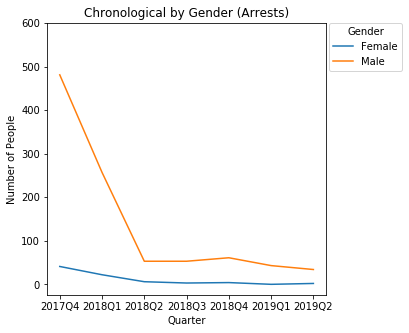

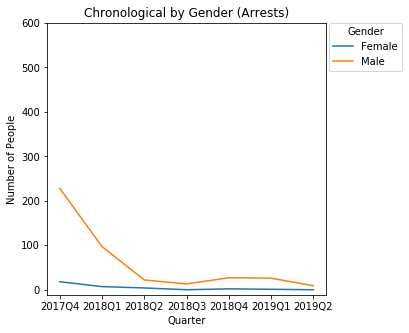

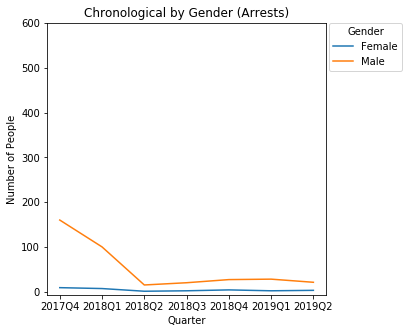

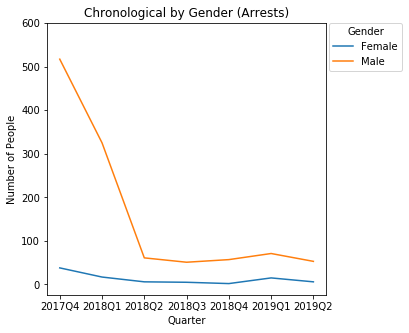

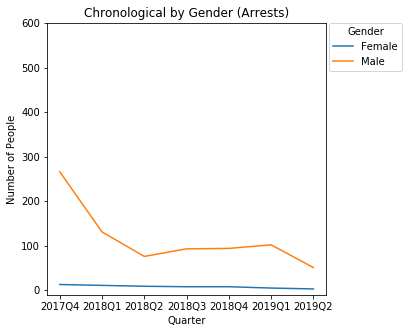

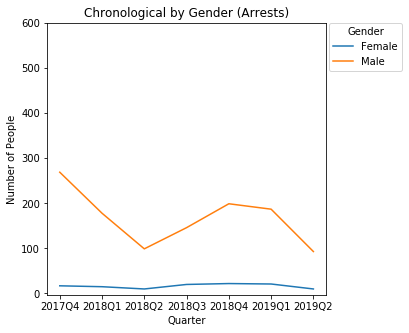

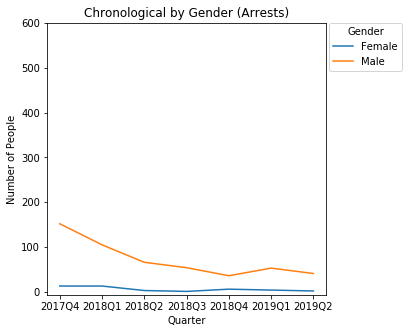

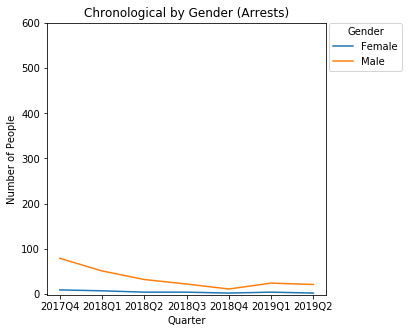

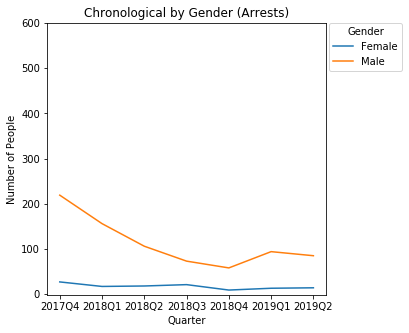

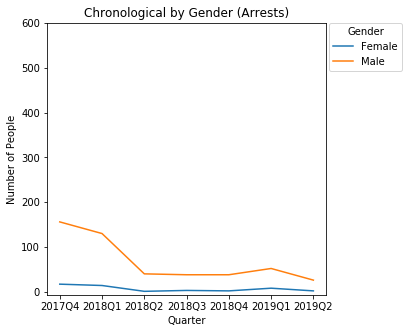

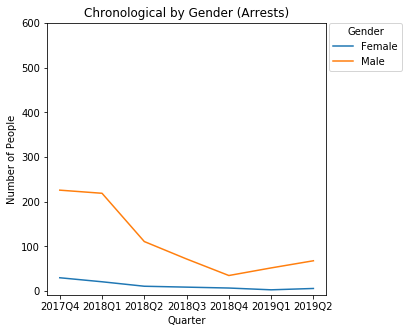

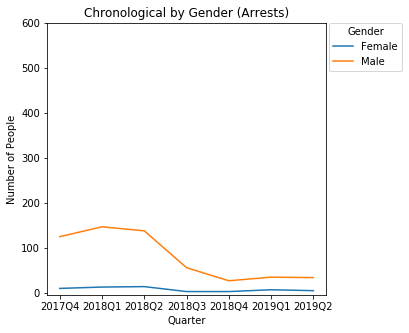

In [9]:
for i in range(0,12):
    plt.figure(figsize=(5, 5))
    values = [float(my_df3.iloc[i, 0]), float(my_df3.iloc[i, 1]), float(my_df3.iloc[i, 2]), 
             float(my_df3.iloc[i, 3]), float(my_df3.iloc[i, 4]), float(my_df3.iloc[i,5]), float(my_df3.iloc[i,6])]
    values1 = [float(my_df3.iloc[i, 7]), float(my_df3.iloc[i, 8]), float(my_df3.iloc[i, 9]), 
              float(my_df3.iloc[i, 10]), float(my_df3.iloc[i, 11]), float(my_df3.iloc[i,12]), float(my_df3.iloc[i,13])]
    plt.plot(values, label='Female')
    plt.plot(values1, label='Male')
    plt.xticks(np.arange(7), ('2017Q4', '2018Q1', '2018Q2', '2018Q3', '2018Q4', '2019Q1', '2019Q2'))
    plt.yticks([0,100,200,300,400,500,600])
    plt.title('Chronological by Gender (Arrests)')
    plt.xlabel('Quarter')
    plt.ylabel('Number of People')
    plt.legend(bbox_to_anchor=(1.29, 1.02), title="Gender")

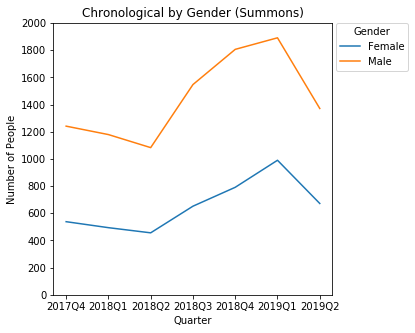

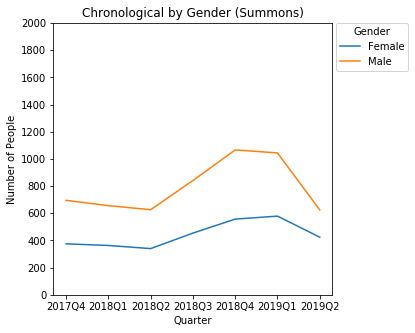

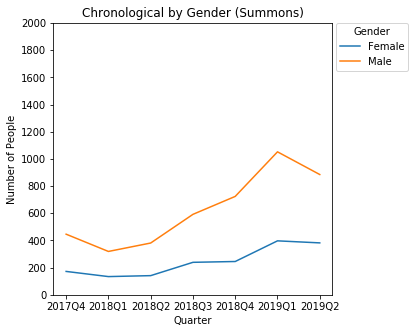

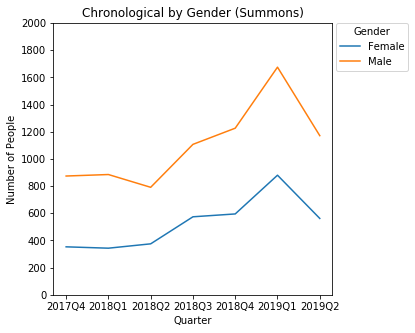

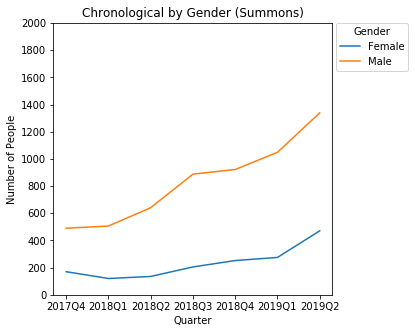

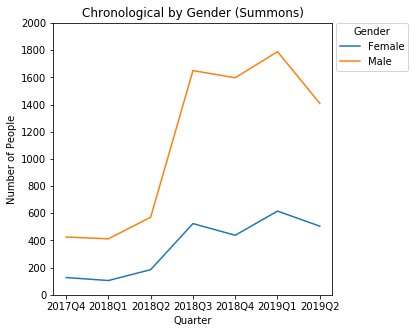

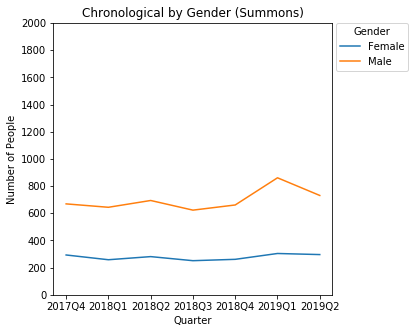

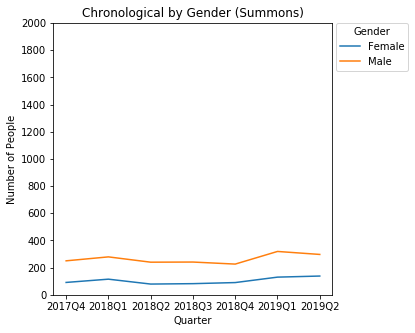

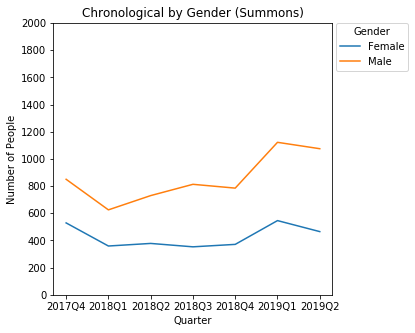

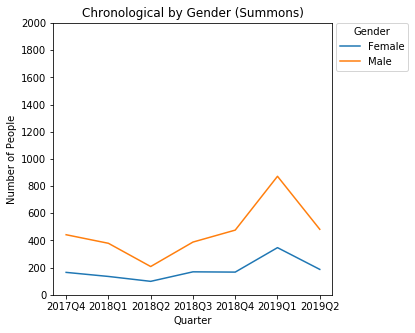

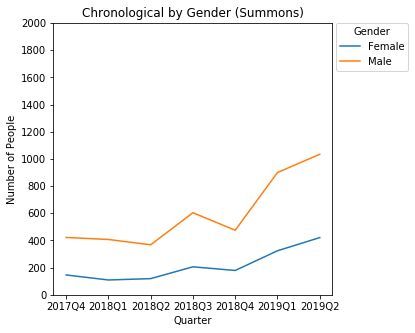

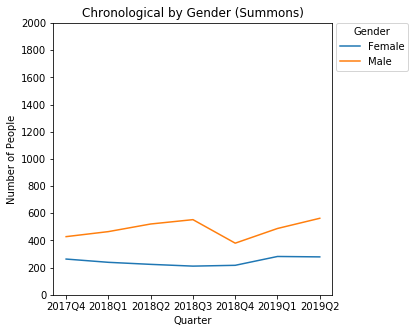

In [10]:
for i in range(0,12):
    plt.figure(figsize=(5, 5))
    values = [float(my_ef3.iloc[i, 0]), float(my_ef3.iloc[i, 1]), float(my_ef3.iloc[i, 2]), 
              float(my_ef3.iloc[i, 3]), float(my_ef3.iloc[i, 4]), float(my_ef3.iloc[i,5]), float(my_ef3.iloc[i,6])]
    values1 = [float(my_ef3.iloc[i, 7]), float(my_ef3.iloc[i, 8]), float(my_ef3.iloc[i, 9]), 
              float(my_ef3.iloc[i, 10]), float(my_ef3.iloc[i, 11]), float(my_ef3.iloc[i,12]), float(my_ef3.iloc[i,13])]
    plt.plot(values, label='Female')
    plt.plot(values1, label='Male')
    plt.xticks(np.arange(7), ('2017Q4', '2018Q1', '2018Q2', '2018Q3', '2018Q4', '2019Q1', '2019Q2'))
    plt.yticks([0,200,400,600,800,1000,1200, 1400, 1600, 1800, 2000])
    plt.title('Chronological by Gender (Summons)')
    plt.xlabel('Quarter')
    plt.ylabel('Number of People')
    plt.legend(bbox_to_anchor=(1.29, 1.02), title="Gender")

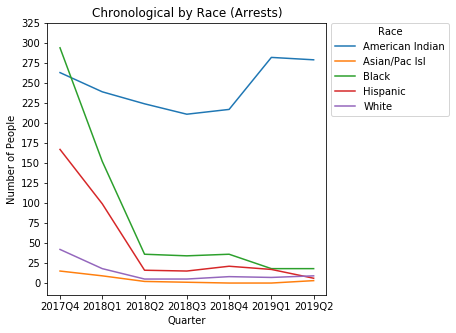

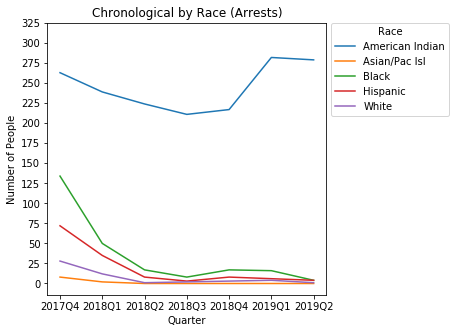

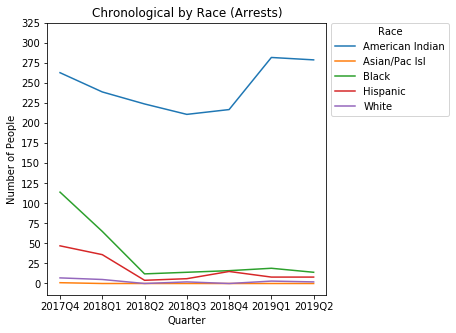

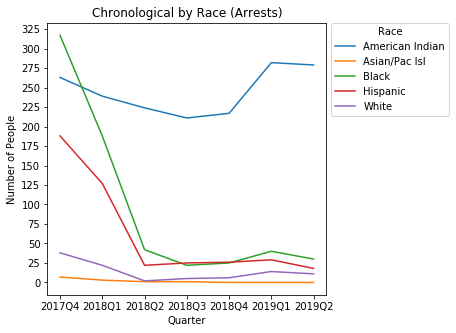

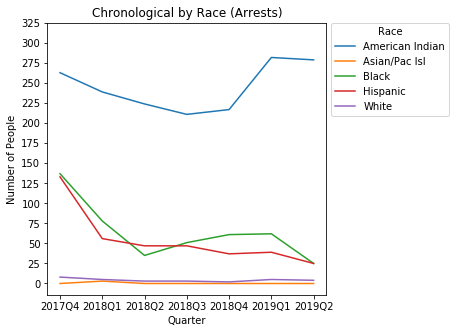

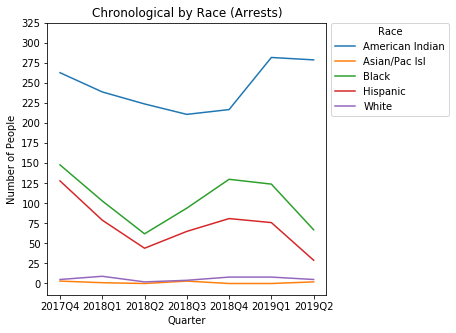

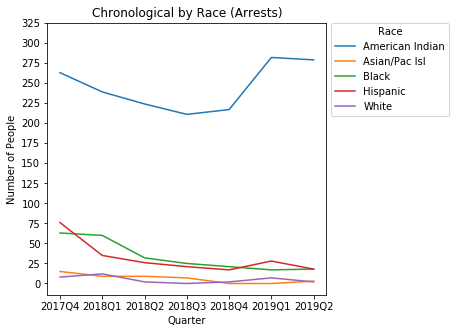

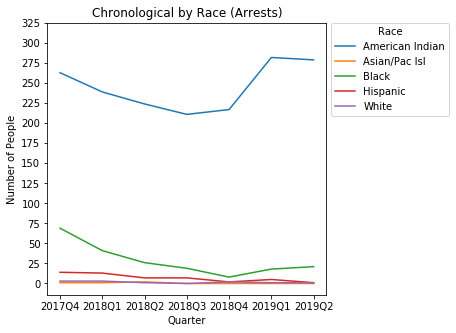

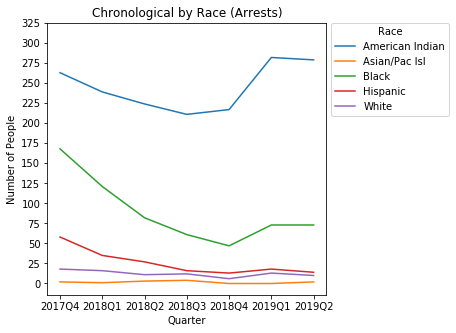

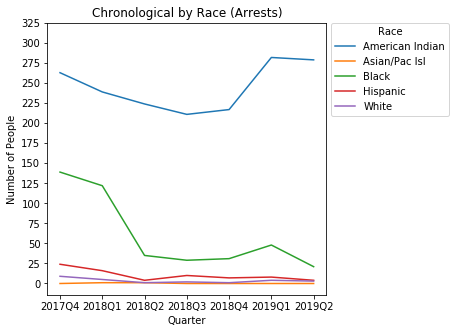

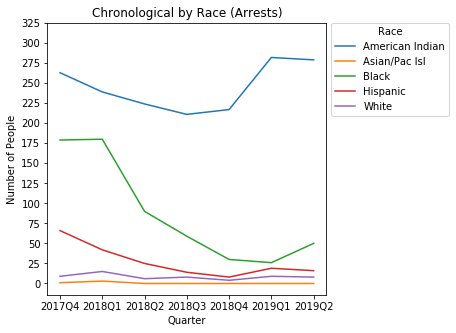

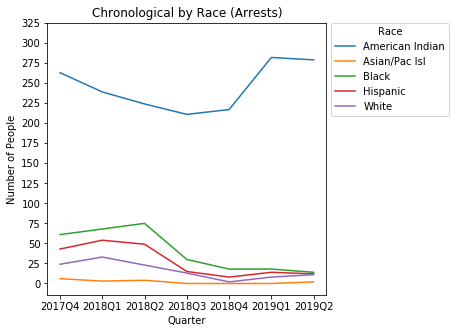

In [11]:
for i in range(0,12):
    plt.figure(figsize=(5, 5))
    values0 = [float(ffs.iloc[i, 0]), float(ffs.iloc[i, 1]), float(ffs.iloc[i, 2]), 
              float(ffs.iloc[i, 3]), float(ffs.iloc[i, 4]), float(ffs.iloc[i,5]), float(ffs.iloc[i,6])]
    
    values1 = [float(ffs.iloc[i, 7]), float(ffs.iloc[i, 8]), float(ffs.iloc[i, 9]), 
              float(ffs.iloc[i, 10]), float(ffs.iloc[i, 11]), float(ffs.iloc[i,12]), float(ffs.iloc[i,13])]
    
    values2 = [float(ffs.iloc[i, 14]), float(ffs.iloc[i, 15]), float(ffs.iloc[i, 16]), 
              float(ffs.iloc[i, 17]), float(ffs.iloc[i, 18]), float(ffs.iloc[i,19]), float(ffs.iloc[i,20])]
    
    values3 = [float(ffs.iloc[i, 21]), float(ffs.iloc[i, 22]), float(ffs.iloc[i, 23]), 
              float(ffs.iloc[i, 24]), float(ffs.iloc[i, 25]), float(ffs.iloc[i,26]), float(ffs.iloc[i,27])]
    
    values4 = [float(ffs.iloc[i, 28]), float(ffs.iloc[i, 29]), float(ffs.iloc[i, 30]), 
              float(ffs.iloc[i, 31]), float(ffs.iloc[i, 32]), float(ffs.iloc[i,33]), float(ffs.iloc[i,34])]
    plt.plot(values, label='American Indian')
    plt.plot(values1, label='Asian/Pac Isl')
    plt.plot(values2, label='Black')
    plt.plot(values3, label='Hispanic')
    plt.plot(values4, label='White')
    plt.xticks(np.arange(7), ('2017Q4', '2018Q1', '2018Q2', '2018Q3', '2018Q4', '2019Q1', '2019Q2'))
    plt.yticks([0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325])
    plt.title('Chronological by Race (Arrests)')
    plt.xlabel('Quarter')
    plt.ylabel('Number of People')
    plt.legend(bbox_to_anchor=(1, 1.02), title="Race")

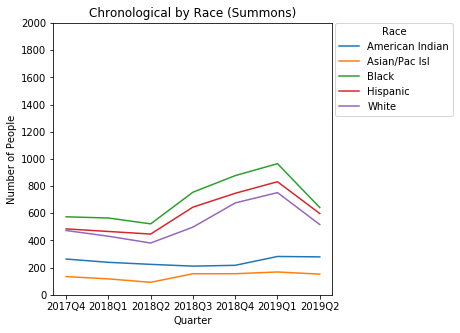

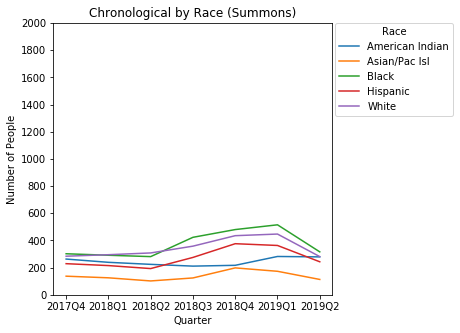

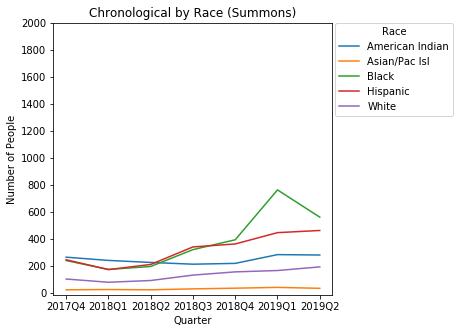

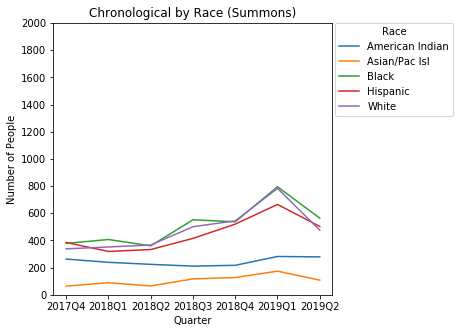

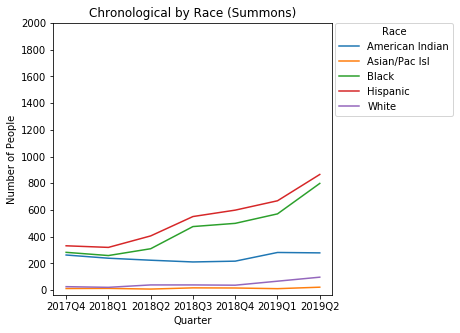

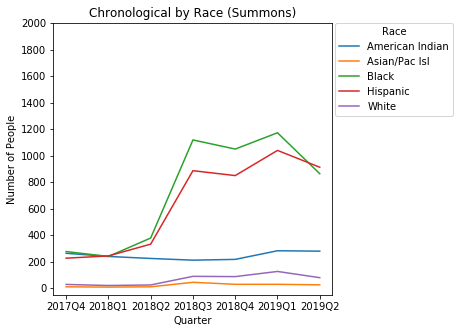

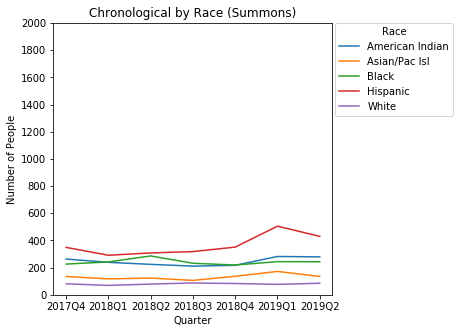

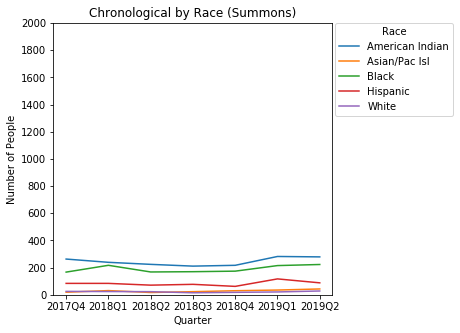

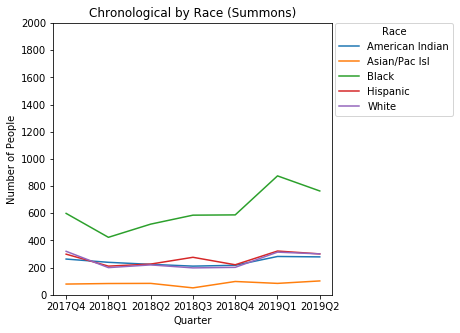

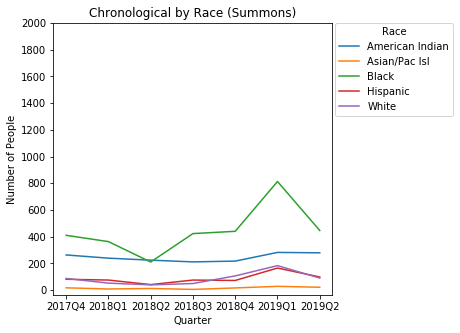

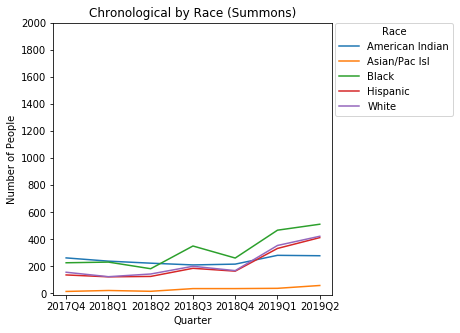

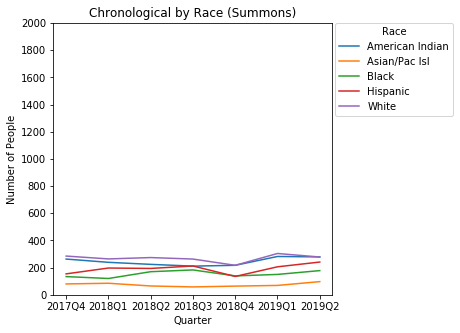

In [12]:
for i in range(0,12):
    plt.figure(figsize=(5, 5))
    values0 = [float(gfs.iloc[i, 0]), float(gfs.iloc[i, 1]), float(gfs.iloc[i, 2]), 
              float(gfs.iloc[i, 3]), float(gfs.iloc[i, 4]), float(gfs.iloc[i,5]), float(gfs.iloc[i,6])]
    
    values1 = [float(gfs.iloc[i, 7]), float(gfs.iloc[i, 8]), float(gfs.iloc[i, 9]), 
              float(gfs.iloc[i, 10]), float(gfs.iloc[i, 11]), float(gfs.iloc[i,12]), float(gfs.iloc[i,13])]
    
    values2 = [float(gfs.iloc[i, 14]), float(gfs.iloc[i, 15]), float(gfs.iloc[i, 16]), 
              float(gfs.iloc[i, 17]), float(gfs.iloc[i, 18]), float(gfs.iloc[i,19]), float(gfs.iloc[i,20])]
    
    values3 = [float(gfs.iloc[i, 21]), float(gfs.iloc[i, 22]), float(gfs.iloc[i, 23]), 
              float(gfs.iloc[i, 24]), float(gfs.iloc[i, 25]), float(gfs.iloc[i,26]), float(gfs.iloc[i,27])]
    
    values4 = [float(gfs.iloc[i, 28]), float(gfs.iloc[i, 29]), float(gfs.iloc[i, 30]), 
              float(gfs.iloc[i, 31]), float(gfs.iloc[i, 32]), float(gfs.iloc[i,33]), float(gfs.iloc[i,34])]
    plt.plot(values, label='American Indian')
    plt.plot(values1, label='Asian/Pac Isl')
    plt.plot(values2, label='Black')
    plt.plot(values3, label='Hispanic')
    plt.plot(values4, label='White')
    plt.xticks(np.arange(7), ('2017Q4', '2018Q1', '2018Q2', '2018Q3', '2018Q4', '2019Q1', '2019Q2'))
    plt.yticks([0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000])
    plt.title('Chronological by Race (Summons)')
    plt.xlabel('Quarter')
    plt.ylabel('Number of People')
    plt.legend(bbox_to_anchor=(1.45, 1.02), title="Race")

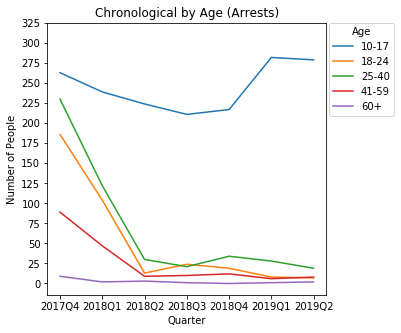

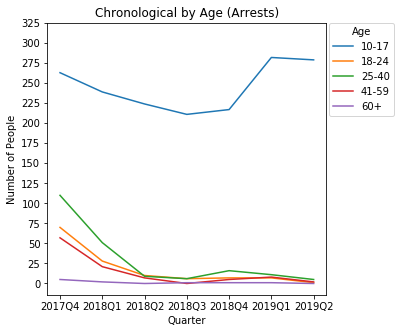

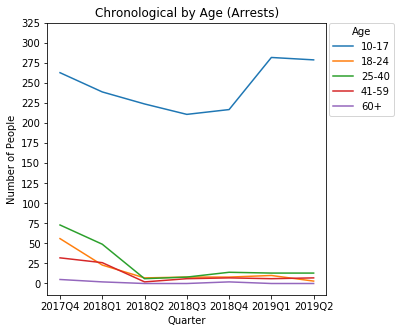

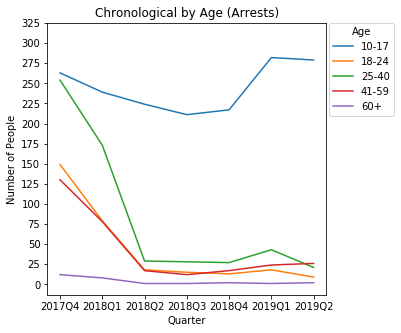

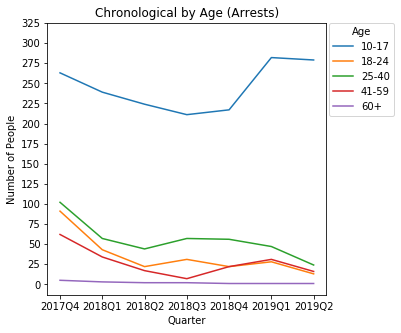

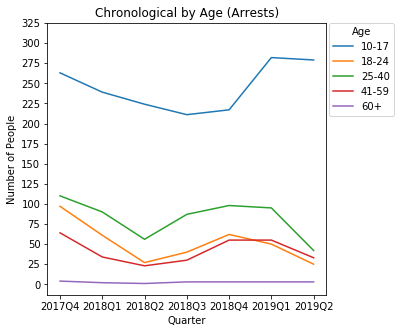

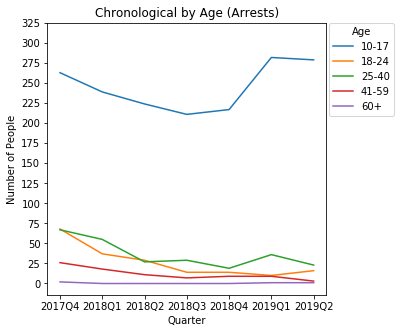

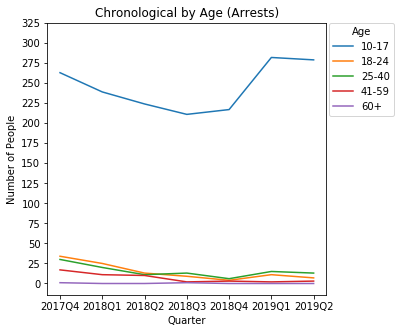

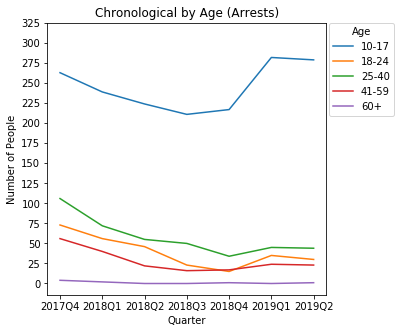

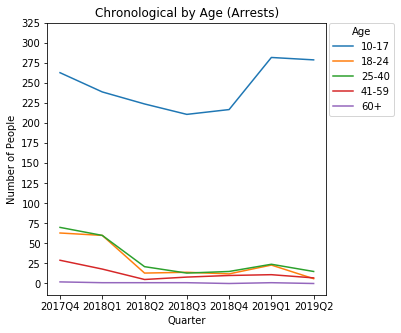

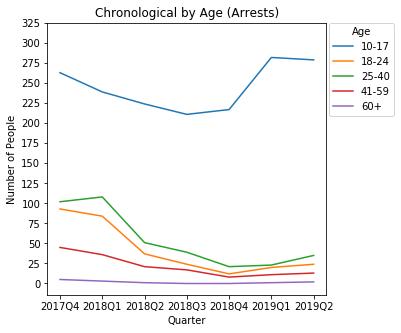

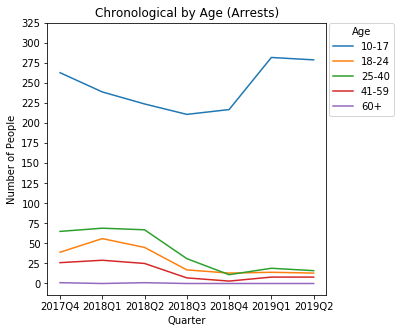

In [13]:
for i in range(0,12):
    plt.figure(figsize=(5, 5))
    values0 = [float(hfs.iloc[i, 0]), float(hfs.iloc[i, 1]), float(hfs.iloc[i, 2]), 
              float(hfs.iloc[i, 3]), float(hfs.iloc[i, 4]), float(hfs.iloc[i,5]), float(hfs.iloc[i,6])]
    
    values1 = [float(hfs.iloc[i, 7]), float(hfs.iloc[i, 8]), float(hfs.iloc[i, 9]), 
              float(hfs.iloc[i, 10]), float(hfs.iloc[i, 11]), float(hfs.iloc[i,12]), float(hfs.iloc[i,13])]
    
    values2 = [float(hfs.iloc[i, 14]), float(hfs.iloc[i, 15]), float(hfs.iloc[i, 16]), 
              float(hfs.iloc[i, 17]), float(hfs.iloc[i, 18]), float(hfs.iloc[i,19]), float(hfs.iloc[i,20])]
    
    values3 = [float(hfs.iloc[i, 21]), float(hfs.iloc[i, 22]), float(hfs.iloc[i, 23]), 
              float(hfs.iloc[i, 24]), float(hfs.iloc[i, 25]), float(hfs.iloc[i,26]), float(hfs.iloc[i,27])]
    
    values4 = [float(hfs.iloc[i, 28]), float(hfs.iloc[i, 29]), float(hfs.iloc[i, 30]), 
              float(hfs.iloc[i, 31]), float(hfs.iloc[i, 32]), float(hfs.iloc[i,33]), float(hfs.iloc[i,34])]
    plt.plot(values, label='10-17')
    plt.plot(values1, label='18-24')
    plt.plot(values2, label='25-40')
    plt.plot(values3, label='41-59')
    plt.plot(values4, label='60+')
    plt.xticks(np.arange(7), ('2017Q4', '2018Q1', '2018Q2', '2018Q3', '2018Q4', '2019Q1', '2019Q2'))
    plt.yticks([0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325])
    plt.title('Chronological by Age (Arrests)')
    plt.xlabel('Quarter')
    plt.ylabel('Number of People')
    #plt.legend(bbox_to_anchor=(1, 1.02), title="Age")
    plt.legend(bbox_to_anchor=(1.26, 1.02), loc='upper right', title="Age")

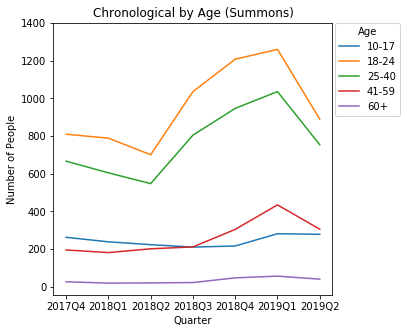

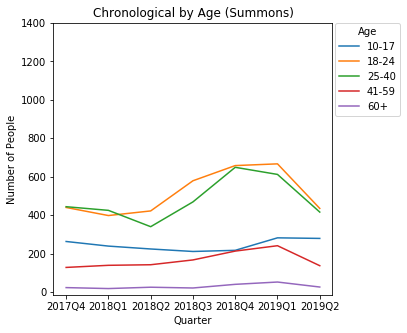

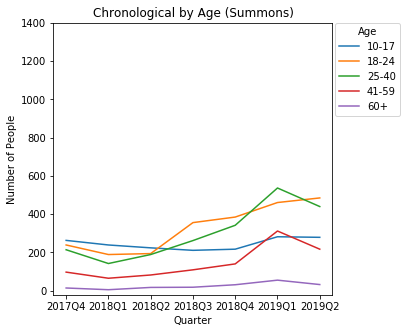

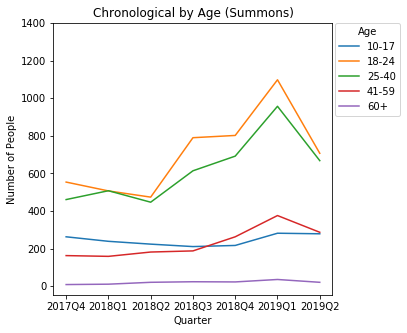

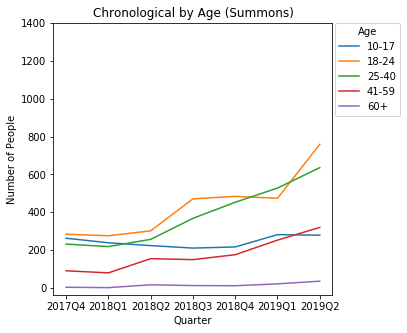

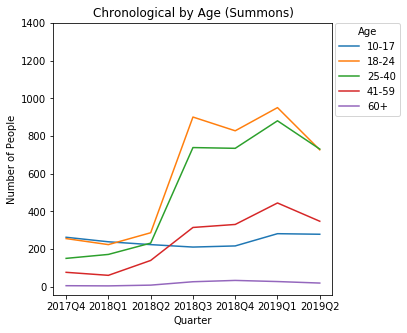

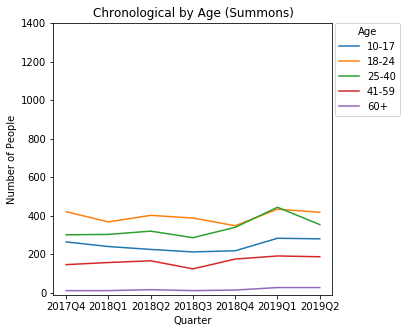

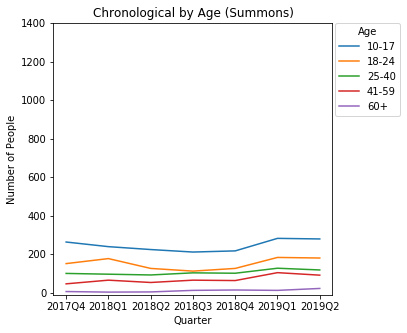

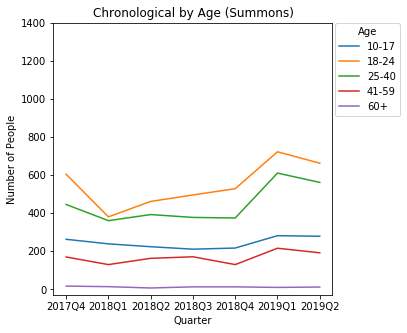

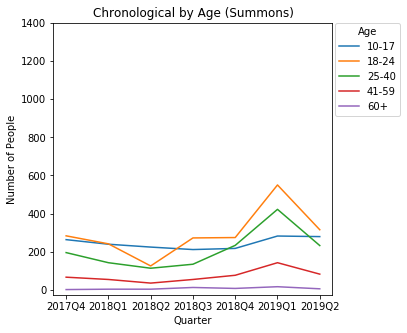

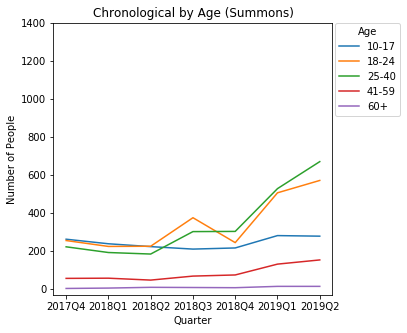

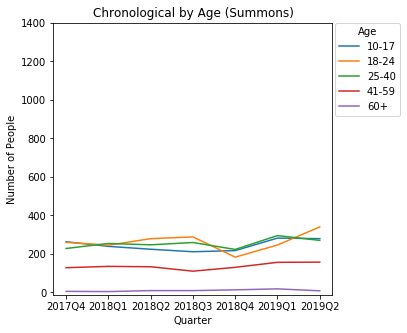

In [14]:
for i in range(0,12):
    plt.figure(figsize=(5, 5))
    values0 = [float(jfs.iloc[i, 0]), float(jfs.iloc[i, 1]), float(jfs.iloc[i, 2]), 
              float(jfs.iloc[i, 3]), float(jfs.iloc[i, 4]), float(jfs.iloc[i,5]), float(jfs.iloc[i,6])]
    
    values1 = [float(jfs.iloc[i, 7]), float(jfs.iloc[i, 8]), float(jfs.iloc[i, 9]), 
              float(jfs.iloc[i, 10]), float(jfs.iloc[i, 11]), float(jfs.iloc[i,12]), float(jfs.iloc[i,13])]
    
    values2 = [float(jfs.iloc[i, 14]), float(jfs.iloc[i, 15]), float(jfs.iloc[i, 16]), 
              float(jfs.iloc[i, 17]), float(jfs.iloc[i, 18]), float(jfs.iloc[i,19]), float(jfs.iloc[i,20])]
    
    values3 = [float(jfs.iloc[i, 21]), float(jfs.iloc[i, 22]), float(jfs.iloc[i, 23]), 
              float(jfs.iloc[i, 24]), float(jfs.iloc[i, 25]), float(jfs.iloc[i,26]), float(jfs.iloc[i,27])]
    
    values4 = [float(jfs.iloc[i, 28]), float(jfs.iloc[i, 29]), float(jfs.iloc[i, 30]), 
              float(jfs.iloc[i, 31]), float(jfs.iloc[i, 32]), float(jfs.iloc[i,33]), float(jfs.iloc[i,34])]
    plt.plot(values, label='10-17')
    plt.plot(values1, label='18-24')
    plt.plot(values2, label='25-40')
    plt.plot(values3, label='41-59')
    plt.plot(values4, label='60+')
    plt.xticks(np.arange(7), ('2017Q4', '2018Q1', '2018Q2', '2018Q3', '2018Q4', '2019Q1', '2019Q2'))
    plt.yticks([0, 200, 400, 600, 800, 1000, 1200, 1400])
    plt.title('Chronological by Age (Summons)')
    plt.xlabel('Quarter')
    plt.ylabel('Number of People')
    plt.legend(bbox_to_anchor=(1.26, 1.02), loc='upper right', title="Age")

# Sources:
https://nyc.streetsblog.org/2019/11/14/mta-will-spend-249m-on-new-cops-to-save-200m-on-fare-evasion/ , defining disparate impact
*These are really really not finished*